_python notebook №3_

## Стадия обученяи сетей DenseNet 121 с применением Transfer learning

In [1]:
import nbimporter
import datasets_bilder # загрузка datasets_bilder.py из репозитория

In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
import seaborn as sns
import torch,torchvision
from  matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import torchvision.utils as vutils
%matplotlib inline

In [3]:
# Для воспроизводимости результатов зафиксируем сиды:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

Функция для отображения картинок

In [5]:
def imshow(img):
    img = img *std_nums[0] + mean_nums[0]  
    img = img.cpu().numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))  
    plt.show()

Функция для визуализации confusion_matrix:

In [6]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## DenseNet121

Загрузим предобученную модель. DenseNet архитектура состоит из четырех плотных блоков с разным количеством слоев.В случае DenseNet-121 [6,12,24,16] слоев в четырех плотных блоках

In [39]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0


In [40]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

У данной сети представлен лишь 1 слой полносвязный под названием classifier с выходным числом нейронов равным 1000. В нашем случае решается задача бинарной классификации, так что данный слой будет иметь по 2 нейрона на выходе.

## _Рассмотрим какие эксперименты мы будем проводить с данной сетью:_

__1) Зафиксируем полностью все сверточные слои и лишь обучим полносвязные слои.__ <br>При этом я поменяю архитектуру полносвязного слоя fc. Я сделаю один скрытый слой с числом нейронов, которое будет в качестве подбираемого гиперпараметра.  Лучший гиперпараметр определим по результатам accuracy на валидационной выборке. <br>Так как фотки исходные чб, то при создании датасетов буду включать параметр RGB_presentation = True, который сделает входные фотки размером (3, 224, 224)

__2) Зафиксируем все сверточные слои кроме первого входного, в котором установим число входных каналов равным 1 вместо 3 + обучим полносвязные слои.__<br>
При этом я поменяю архитектуру полносвязного слоя fc. Я сделаю один скрытый слой с числом нейронов, которое будет в качестве подбираемого гиперпараметра. Лучший гиперпараметр определим по результатам accuracy на валидационной выборке. <br>Так как я поменяю чило каналов на входе сети, поэтому могу обучать на чб снимках, размером (1, 224, 224).


__3) Полностью обучим сеть, ничего в ней не меняя (кроме выходного числа нейронов в полносвязной части).__<br>
Так как фотки исходные чб, то при создании датасетов буду включать параметр RGB_presentation = True, который сделает входные фотки размером (3, 224, 224)

## №1

In [41]:
model.classifier.in_features

1024

In [42]:
n_neurons = 10
# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1024, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 2))

В таком виде переопределим сеть:

In [43]:
model.classifier = fc_new
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Создадим папку, куда загрузим модели:

In [122]:
directory = os.getcwd() + '\models'
if not os.path.exists(directory):
    os.makedirs(directory)

__Проведем обучение 10 эпох для каждого значения подбираемого гиперпараметра:__

Я сделаю один скрытый слой в новом classifier layer с числом нейронов, которое будет в качестве подбираемого гиперпараметра. Лучший гиперпараметр определю по результатам accuracy на валидационной выборке + построю графики изменения метрик accuracy и loss в процессе обучения для каждого значения гиперпараметра. <br> Значения пербираемые n_neurons = 10, 100 и 500

In [8]:
n_neurons_list = [10, 100, 500]

In [9]:
data = datasets_bilder.preprocessing_func(RGB_presentation=True, easy=True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums
batch_size = 10 
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [13]:
directory = os.getcwd() + '\models'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [ ]:
# Задаим словари для отслеживания метрик accuracy и loss в процессе обучения для каждого значения гиперпараметра.
loss_train_dict = {}
acc_train_dict = {}
acc_validation_dict = {}
loss_validation_dict = {}

n_epoch = 10 #Зададим число эпох обучения
start_time = time.time()
for n_neurons in n_neurons_list:
    model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True).to(device)
    # Переопредлим полносвязные слои:
    fc_new =  nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1024, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 2))
    
    model.classifier = fc_new
    # Зафиксируем все слои кроме переназначенного fc
    for name, param in model.named_parameters():
        if not ('classifier' in name):
            param.requires_grad = False
    
    loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

    opt = optim.Adam(model.parameters(), lr=0.001) # Адам-оптимизатор
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)
    
    # Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
    loss_train = []
    acc_train = []
    acc_validation = []
    loss_validation = []
    
    
    maxacc = 0 
    print('НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons, ':')
    for epoch in range(n_epoch): # цикл эпох
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        for batch in tqdm(train_dataloader):
            # получим данные батча
            image_batch, label_batch  = batch
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)

            #Приведу значение label_batch к требуемому виду
            label_batch = torch.flatten(label_batch).type(torch.LongTensor) 

            # обнуление параметров градиента
            opt.zero_grad()

            # forward + backward + optimize
            y_pred = model(image_batch)
            loss = loss_func(y_pred, label_batch)

            loss.backward()
            opt.step()

            #среднее по так будем искать (складывать а потом делить число батчей):
            running_loss += loss.item() 
            running_acc += accuracy(y_pred, label_batch)

        print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                          running_acc / len(train_dataloader)))
        loss_train.append(running_loss / len(train_dataloader))
        acc_train.append(running_acc / len(train_dataloader))
        scheduler.step() # шаг для lr_scheduler

        model.eval()  #Перевод модели в режим тестирования
        acc_val = []
        running_loss_val = 0
        for itr,data in enumerate(val_dataloader):
                imgs = data[0].to(device)
                labels = data[1].to(device)   
                labels = torch.flatten(labels).type(torch.LongTensor)
                y_pred = model(imgs)
                acc_val.append(accuracy(y_pred,labels))
                running_loss_val += loss.item()
        loss_val_ep =  running_loss_val / len(val_dataloader)

        acc_val_ep = np.mean(np.array(acc_val))
        print(f'Validation accuracy - {acc_val_ep}')
        acc_validation.append(acc_val_ep)
        loss_validation.append(loss_val_ep)


        # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
        if np.mean(np.array(acc_val)) > maxacc:
                maxacc = np.mean(np.array(acc_val)) 
                torch.save(model, directory+'\model_DenseNet121_1_n='+str(n_neurons)+'.pth')
                
    print('ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons)    
    
    # Добавим в словари значения изменения метрик в процессе обучения для текущего значения гиперпараметра
    loss_train_dict[n_neurons] = loss_train
    acc_train_dict[n_neurons] = acc_train
    acc_validation_dict[n_neurons] = acc_validation
    loss_validation_dict[n_neurons] = loss_validation
        
print('Total time {:.1f} seconds'.format(time.time() - start_time))

НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [23:05<00:00,  2.58s/it]


[epoch 1] loss: 0.307, acc: 0.881
Validation accuracy - 0.8843749999999999


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [23:09<00:00,  2.59s/it]


[epoch 2] loss: 0.219, acc: 0.918
Validation accuracy - 0.871875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [23:00<00:00,  2.57s/it]


[epoch 3] loss: 0.205, acc: 0.921
Validation accuracy - 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [23:01<00:00,  2.57s/it]


[epoch 4] loss: 0.199, acc: 0.92
Validation accuracy - 0.8625


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [23:03<00:00,  2.58s/it]


[epoch 5] loss: 0.195, acc: 0.922
Validation accuracy - 0.896875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:54<00:00,  2.56s/it]


[epoch 6] loss: 0.171, acc: 0.934
Validation accuracy - 0.878125


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:41<00:00,  2.53s/it]


[epoch 7] loss: 0.163, acc: 0.936
Validation accuracy - 0.8656250000000001


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:42<00:00,  2.54s/it]


[epoch 8] loss: 0.167, acc: 0.934
Validation accuracy - 0.846875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:40<00:00,  2.53s/it]


[epoch 9] loss: 0.165, acc: 0.933
Validation accuracy - 0.853125


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:35<00:00,  2.52s/it]


[epoch 10] loss: 0.178, acc: 0.929
Validation accuracy - 0.8531249999999999
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10
НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 100 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:42<00:00,  2.54s/it]


[epoch 1] loss: 0.269, acc: 0.891
Validation accuracy - 0.89375


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:42<00:00,  2.54s/it]


[epoch 2] loss: 0.228, acc: 0.909
Validation accuracy - 0.865625


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:41<00:00,  2.54s/it]


[epoch 3] loss: 0.192, acc: 0.922
Validation accuracy - 0.86875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:44<00:00,  2.54s/it]


[epoch 4] loss: 0.195, acc: 0.922
Validation accuracy - 0.8593749999999999


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:40<00:00,  2.53s/it]


[epoch 5] loss: 0.191, acc: 0.926
Validation accuracy - 0.81875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:40<00:00,  2.53s/it]


[epoch 6] loss: 0.161, acc: 0.936
Validation accuracy - 0.86875


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:40<00:00,  2.53s/it]


[epoch 7] loss: 0.144, acc: 0.943
Validation accuracy - 0.859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:45<00:00,  2.54s/it]


[epoch 8] loss: 0.148, acc: 0.94
Validation accuracy - 0.8625


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:41<00:00,  2.54s/it]


[epoch 9] loss: 0.144, acc: 0.942
Validation accuracy - 0.865625


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:42<00:00,  2.54s/it]


[epoch 10] loss: 0.138, acc: 0.946
Validation accuracy - 0.871875
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 100
НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 500 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [22:55<00:00,  2.56s/it]


[epoch 1] loss: 0.274, acc: 0.886
Validation accuracy - 0.853125


 88%|███████████████████████████████████████████████████████████████████████████████████▏          | 475/537 [20:19<02:30,  2.43s/it]

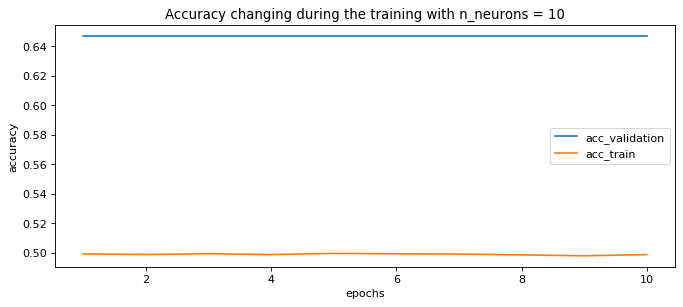

KeyError: 100

In [56]:
for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    acc_train = acc_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Accuracy changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='acc_validation')
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='acc_train')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')  
    plt.show()

In [ ]:
for i in n_neurons_list:
    loss_validation = loss_validation_dict[i]
    loss_train = loss_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Cross Entropy Loss changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), loss_validation, label='loss_validation')
    plt.plot(list(range(1, n_epoch+1)), loss_train, label='loss_train')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(loc='best')  
    plt.show()

In [ ]:
plt.figure(figsize=(10, 5), dpi=80)
plt.title('Validation accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

KeyError: 100

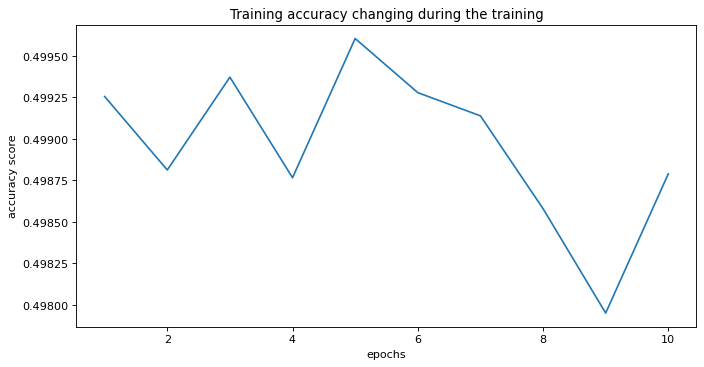

In [57]:
plt.figure(figsize=(10, 5), dpi=80)
plt.title('Training accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_val = acc_train_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

In [58]:
table = [list(range(1,n_epoch+1))]
columns = ['epoch']
for i, val in enumerate(n_neurons_list):
    table.append(acc_validation_dict[val])
    columns.append(str(val)+' neurons')
table = np.asarray(table).T
print('Validation accuracy change:')
pd.DataFrame(table, columns=columns)

KeyError: 100

In [59]:
acc_validation_dict_1 = acc_validation_dict
acc_train_dict_1 = acc_train_dict

Самый высокий показатель accuracy на валидации показал гиперпараметр * на * эпохе обучения. Так что загрузим именно эту модель:

In [27]:
!!!Испрвь номер !!! wghts = torch.load(directory + '\model_ResNet18_1_n='+str(100)+'.pth')
model.load_state_dict(wghts.state_dict())

<All keys matched successfully>

Оценим качество этой модели на test:

In [28]:
model.eval()
y_true_list = []
y_pred_list = []
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        y_true_list.append(label_batch.numpy())
        y_pred_list.append(predicted.numpy())
        
        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

Точность модели на test: 48.75 %


In [29]:
y_pred_list = np.asarray(y_pred_list).flatten()
y_true_list = np.asarray(y_true_list).flatten()
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.38      0.45      0.41       129
           1       0.58      0.51      0.54       191

    accuracy                           0.49       320
   macro avg       0.48      0.48      0.48       320
weighted avg       0.50      0.49      0.49       320



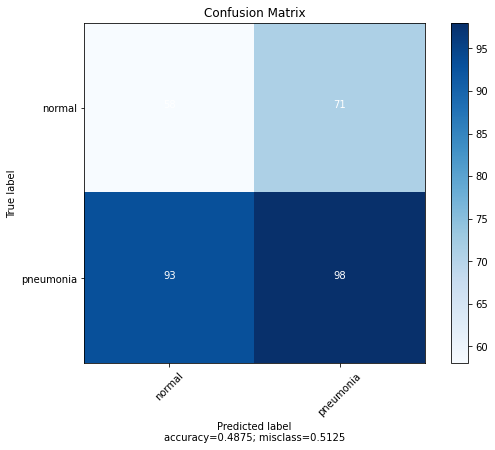

In [35]:
cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['normal','pneumonia'],
                      title        = "Confusion Matrix")

In [ ]:
image_batch, label_batch = next(iter(test_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(15, 9), dpi=80)
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ' '.join('%5s' % classes[int(label_batch[j])] for j in range(batch_size)))
outputs = model(image_batch)
predicted = torch.argmax(outputs, dim=1)

print('Прогноз: '," ".join(classes[predicted[j]]for j in range(batch_size)))

---

## №2

In [37]:
    model.features.conv0 =  nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)    
    for name, param in model.named_parameters():
        if not (('conv0' in name) or ('classifier' in name)):
            param.requires_grad = False
            print(name)

features.norm0.weight
features.norm0.bias
features.denseblock1.denselayer1.norm1.weight
features.denseblock1.denselayer1.norm1.bias
features.denseblock1.denselayer1.conv1.weight
features.denseblock1.denselayer1.norm2.weight
features.denseblock1.denselayer1.norm2.bias
features.denseblock1.denselayer1.conv2.weight
features.denseblock1.denselayer2.norm1.weight
features.denseblock1.denselayer2.norm1.bias
features.denseblock1.denselayer2.conv1.weight
features.denseblock1.denselayer2.norm2.weight
features.denseblock1.denselayer2.norm2.bias
features.denseblock1.denselayer2.conv2.weight
features.denseblock1.denselayer3.norm1.weight
features.denseblock1.denselayer3.norm1.bias
features.denseblock1.denselayer3.conv1.weight
features.denseblock1.denselayer3.norm2.weight
features.denseblock1.denselayer3.norm2.bias
features.denseblock1.denselayer3.conv2.weight
features.denseblock1.denselayer4.norm1.weight
features.denseblock1.denselayer4.norm1.bias
features.denseblock1.denselayer4.conv1.weight
featur

__Зафиксируем все сверточные слои кроме первого входного, в котором установим число входных каналов равным 1 вместо 3 + обучим полносвязные слои.__<br>
При этом я поменяю архитектуру полносвязного слоя classifier. Я сделаю один скрытый слой с числом нейронов, которое будет в качестве подбираемого гиперпараметра. Лучший гиперпараметр определим по результатам accuracy на валидационной выборке. <br>Так как я поменяю чило каналов на входе сети, поэтому могу обучать на чб снимках, размером (1, 224, 224).


In [36]:
data = datasets_bilder.preprocessing_func(easy=True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums
batch_size = 10 
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [37]:
directory = os.getcwd() + '\models'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [38]:
loss_train_dict = {}
acc_train_dict = {}
acc_validation_dict = {}
loss_validation_dict = {}

n_epoch = 10 #Зададим число эпох обучения
start_time = time.time()
for n_neurons in neurons_list:
    
    model_2 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True).to(device)
    
    # Переопредлим полносвязные слои:
    fc_new =  nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1024, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 2))
    
    model_2.classifier = fc_new
    
    # Переопределим первый сверточный слой сети, сделав 1 входной канал
    model_2.features.conv0 =  nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)    
    
    for name, param in model_2.named_parameters():
        if not (('conv0' in name) or ('classifier' in name)):
            param.requires_grad = False
    
    loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

    opt = optim.Adam(model_2.parameters(), lr=0.001) # Адам-оптимизатор
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)

    # Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
    loss_train = []
    acc_train = []
    acc_validation = []
    loss_validation = []

    maxacc = 0 
    print('НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons, ':')
    for epoch in range(n_epoch): # цикл эпох
        model_2.train()
        running_loss = 0.0
        running_acc = 0.0
        for batch in tqdm(train_dataloader):
            # получим данные батча
            image_batch, label_batch  = batch
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)

            #Приведу значение label_batch к требуемому виду
            label_batch = torch.flatten(label_batch).type(torch.LongTensor) 

            # обнуление параметров градиента
            opt.zero_grad()

            # forward + backward + optimize
            y_pred = model_2(image_batch)
            loss = loss_func(y_pred, label_batch)

            loss.backward()
            opt.step()

            #среднее по так будем искать (складывать а потом делить число батчей):
            running_loss += loss.item() 
            running_acc += accuracy(y_pred, label_batch)

        print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                          running_acc / len(train_dataloader)))
        loss_train.append(running_loss / len(train_dataloader))
        acc_train.append(running_acc / len(train_dataloader))
        scheduler.step() # шаг для lr_scheduler

        model_2.eval()  #Перевод модели в режим тестирования
        acc_val = []
        running_loss_val = 0
        for itr,data in enumerate(val_dataloader):
                imgs = data[0].to(device)
                labels = data[1].to(device)   
                labels = torch.flatten(labels).type(torch.LongTensor)
                y_pred = model_2(imgs)
                acc_val.append(accuracy(y_pred,labels))
                running_loss_val += loss.item()
        loss_val_ep =  running_loss_val / len(val_dataloader)

        acc_val_ep = np.mean(np.array(acc_val))
        print(f'Validation accuracy - {acc_val_ep}')
        acc_validation.append(acc_val_ep)
        loss_validation.append(loss_val_ep)


        # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
        if np.mean(np.array(acc_val)) > maxacc:
                maxacc = np.mean(np.array(acc_val)) 
                torch.save(model_2, directory+'\model_DenseNet121_2_n='+str(n_neurons)+'.pth')
                
    print('ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons)    
    
    # Добавим в словари значения изменения метрик в процессе обучения для текущего значения гиперпараметра
    loss_train_dict[n_neurons] = loss_train
    acc_train_dict[n_neurons] = acc_train
    acc_validation_dict[n_neurons] = acc_validation
    loss_validation_dict[n_neurons] = loss_validation
        
print('Total time {:.1f} seconds'.format(time.time() - start_time))

НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [03:11<00:00,  1.40it/s]


[epoch 1] loss: 0.737, acc: 0.473
Validation accuracy - 0.35625


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [03:14<00:00,  1.39it/s]


[epoch 2] loss: 0.745, acc: 0.45
Validation accuracy - 0.3375
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10
НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 100 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [03:15<00:00,  1.38it/s]


[epoch 1] loss: 0.709, acc: 0.496
Validation accuracy - 0.49375


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [03:14<00:00,  1.38it/s]


[epoch 2] loss: 0.708, acc: 0.497
Validation accuracy - 0.49375
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 100
НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 500 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [03:17<00:00,  1.36it/s]


[epoch 1] loss: 0.763, acc: 0.468
Validation accuracy - 0.6


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [03:14<00:00,  1.38it/s]


[epoch 2] loss: 0.76, acc: 0.471
Validation accuracy - 0.596875
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 500
Total time 1230.8 seconds


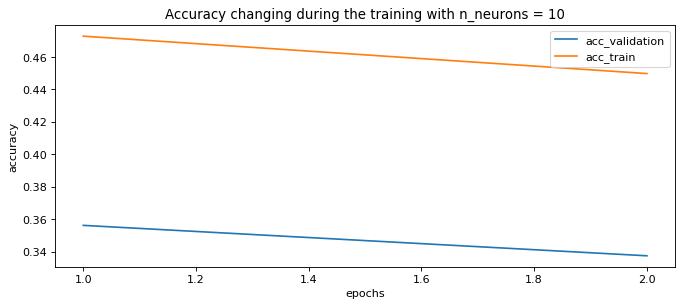

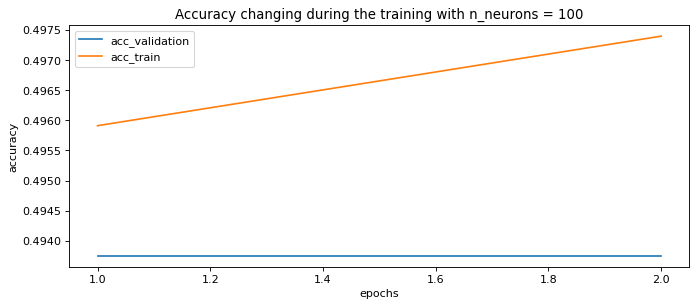

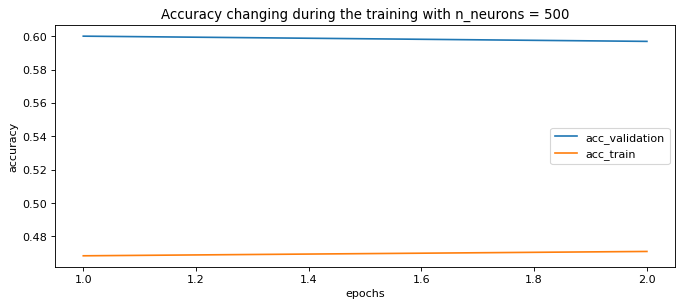

In [41]:
for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    acc_train = acc_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Accuracy changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='acc_validation')
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='acc_train')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')  
    plt.show()

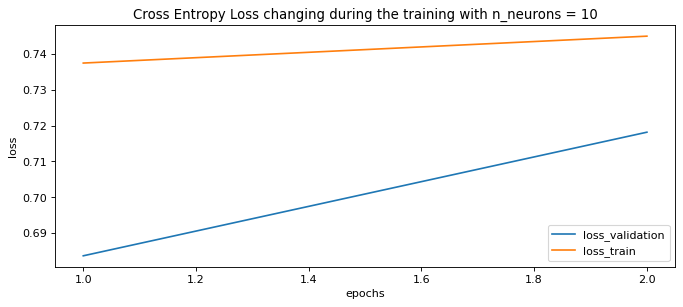

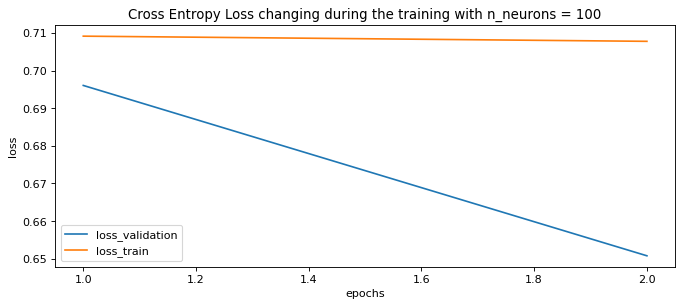

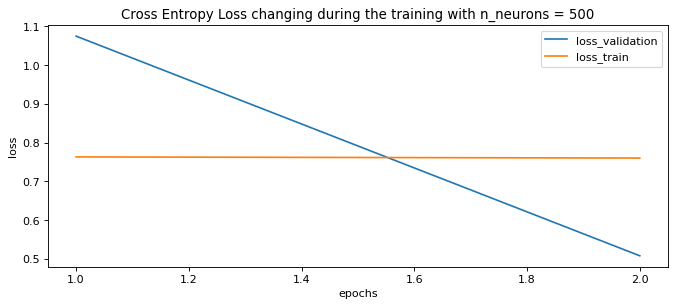

In [42]:
for i in n_neurons_list:
    loss_validation = loss_validation_dict[i]
    loss_train = loss_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Cross Entropy Loss changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), loss_validation, label='loss_validation')
    plt.plot(list(range(1, n_epoch+1)), loss_train, label='loss_train')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(loc='best')  
    plt.show()

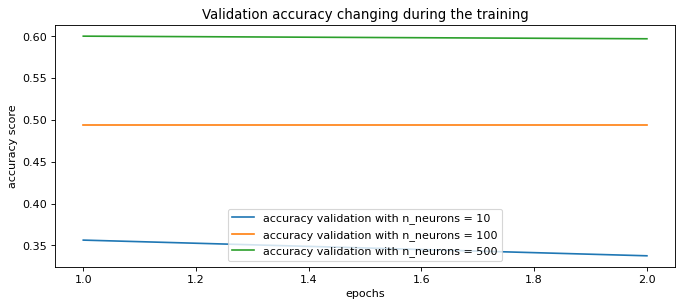

In [43]:
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Validation accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

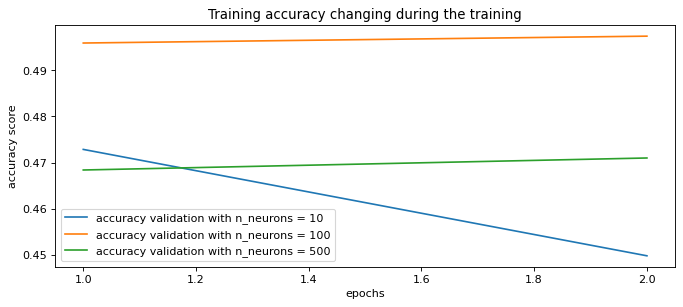

In [46]:
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Training accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_train = acc_train_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

In [47]:
table = [list(range(1,n_epoch+1))]
columns = ['epoch']
for i, val in enumerate(n_neurons_list):
    table.append(acc_validation_dict[val])
    columns.append(str(val)+' neurons')
table = np.asarray(table).T
print('Validation accuracy change:')
pd.DataFrame(table, columns=columns)

Validation accuracy change:


,epoch,10 neurons,100 neurons,500 neurons
0,1.0,0.35625,0.49375,0.600000
1,2.0,0.33750,0.49375,0.596875


## №3

__Полностью обучим сеть, ничего в ней не меняя (кроме выходного числа нейронов в полносвязной части).__ <br>
Так как фотки исходные чб, то при создании датасетов буду включать параметр RGB_presentation = True, который сделает входные фотки размером (3, 224, 224)

In [48]:
data = datasets_bilder.preprocessing_func(RGB_presentation=True, easy=True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums
batch_size = 10 
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [49]:
n_epoch = 15

In [50]:
directory = os.getcwd() + '\models'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [51]:
model_3 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True).to(device)

# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
                nn.Linear(1024, 2))
model_3.classifire = fc_new
    
for name, param in model_3.named_parameters():
    param.requires_grad = True

loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

opt = optim.Adam(model_3.parameters(), lr=0.001) # Адам-оптимизатор
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)   

# Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
loss_train = []
acc_train = []
acc_validation = []
loss_validation = []

start_time = time.time()
maxacc = 0 
for epoch in range(n_epoch): # цикл эпох
    model_3.train() # Перевод модели в режим обучения
    running_loss = 0.0
    running_acc = 0.0
    for batch in tqdm(train_dataloader):
        # получим данные батча
        image_batch, label_batch  = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        #Приведу значение label_batch к требуемому виду
        label_batch = torch.flatten(label_batch).type(torch.LongTensor) 
        
        # обнуление параметров градиента
        opt.zero_grad()

        # forward + backward + optimize
        y_pred = model_3(image_batch)
        loss = loss_func(y_pred, label_batch)
        
        loss.backward()
        opt.step()
        
        #среднее по так будем искать (складывать а потом делить число батчей):
        running_loss += loss.item() 
        running_acc += accuracy(y_pred, label_batch)
        
    print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                      running_acc / len(train_dataloader)))
    loss_train.append(running_loss / len(train_dataloader))
    acc_train.append(running_acc / len(train_dataloader))
    scheduler.step() # шаг для lr_scheduler

    model_3.eval()  #Перевод модели в режим тестирования
    acc_val = []
    running_loss_val = 0
    for itr,data in enumerate(val_dataloader):
            imgs = data[0].to(device)
            labels = data[1].to(device)   
            labels = torch.flatten(labels).type(torch.LongTensor)
            y_pred = model_3(imgs)
            acc_val.append(accuracy(y_pred,labels))
            running_loss_val += loss.item()
    loss_val_ep =  running_loss_val / len(val_dataloader)

    acc_val_ep = np.mean(np.array(acc_val))
    print(f'Validation accuracy - {acc_val_ep}')
    acc_validation.append(acc_val_ep)
    loss_validation.append(loss_val_ep)

    
    # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
    if np.mean(np.array(acc_val)) > maxacc:
            maxacc = np.mean(np.array(acc_val)) 
            torch.save(model_3, directory+'\model_DenseNet121_full_train.pth')
            
print('Total time {:.3f} seconds'.format(time.time() - start_time))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [13:29<00:00,  3.01s/it]


[epoch 1] loss: 0.71, acc: 0.512
Validation accuracy - 0.703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [13:22<00:00,  2.98s/it]


[epoch 2] loss: 0.706, acc: 0.525
Validation accuracy - 0.70625
Total time 1750.095 seconds
